<a href="https://colab.research.google.com/github/javier-jaime/Reinforcement_Learning_Demos/blob/main/Pick_up_and_Drop_off_RL_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Deep Learning and Reinforcement Learning

## Package Pick up and Drop off Route Optimization with Reinforcement Learning

Based on:  https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

In [30]:
import gym
import os
import time
import pandas as pd
import numpy as np
import random
from IPython.display import clear_output
import seaborn as sns
from collections import deque
from collections import defaultdict
from time import sleep
import sys
import math

## This Project use the Taxi-v3 Environment
from OpenAI Gym (https://gym.openai.com/docs/)

The job is to pick up a package at one location and drop him off in the right location in the minimum time possible.

In [31]:
env = gym.make("Taxi-v3").env # Build a fresh environment

In [32]:
env.render() # Renders one frame of the environment 

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [33]:
env.reset()  # Resets the environment and returns a random initial state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


### Action/State Space

We have 6 possible actions:
0 = south,
1 = north,
2 = east,
3 = west,
4 = pickup &
5 = dropoff

And 4 possible pickup and destination locations: R, G, Y & B.

The blue letter represents the current pick-up location, and the purple letter is the current destination. The filled square represents the vehicle, which is yellow without a package and green with one. The pipe ("|") represents a wall which the vehicle cannot cross.

In [34]:
state = env.encode(3, 2, 1, 0) # (row, column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 344
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [35]:
env.P[344] # Dictionary with structure: {action: [(probability, nextstate, reward, done)]}

{0: [(1.0, 444, -1, False)],
 1: [(1.0, 244, -1, False)],
 2: [(1.0, 344, -1, False)],
 3: [(1.0, 324, -1, False)],
 4: [(1.0, 344, -10, False)],
 5: [(1.0, 344, -10, False)]}

### Try to Solve the environment with brute force (random) and not RL
Rewards: You will receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes.

There is also a 10 point penalty for illegal pick-up and drop-off actions.

In [36]:
env.s = 344  # set environment to the state above

epochs = 0
penalties = 0
reward = 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample() # we can randomly sample actions
    state, reward, done, info = env.step(action) # Step the environment by one timestep

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    epochs += 1
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1705
Penalties incurred: 553


In [37]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1705
State: 0
Action: 5
Reward: 20


Not good! It took a lot of steps for only one drop.

## Q-Learning

Q-values are updated using the equation:

Q(state,action)←(1−α)Q(state,action)+α(reward+γmaxaQ(next state,all actions))

Where:
- α (alpha) is the learning rate (0<α≤1)
- γ (gamma) is the discount factor (0≤γ≤1)

The Q-table is a matrix where we have a row for every state (500) and a column for every action (6). 

In [38]:
q_table = np.zeros([env.observation_space.n, env.action_space.n]) # Initialize the Q-table by all zeros

### Training the agent (See below for Hyperparameters Optimization)

In [39]:
%%time

max_episodes = 500000

# Set Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For storing and plotting the metrics
all_epochs = []
all_penalties = []

random_seed= 42 # 42 is The Answer To Life, The Universe and Everything
rng =np.random.default_rng(random_seed)

for i in range(1, max_episodes+1):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if rng.random() < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 1000 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 500000
Training finished.

CPU times: user 4min 7s, sys: 34 s, total: 4min 41s
Wall time: 4min 7s


In [40]:
# From the Q-Table if we are in the state 344 from above, we should go north

print(q_table[344], "max value", max(q_table[344]), "is in place 1, this is north")

[ -2.49364522  -2.48236806  -2.48942067  -2.49365213 -11.48815677
 -11.48881832] max value -2.482368063078398 is in place 1, this is north


### Evaluating the Agent

In [41]:
total_epochs, total_penalties = 0, 0
episodes = 1000

for _ in range(episodes):
    state = env.reset()  # reset environment to a new, random state
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 1000 episodes:
Average timesteps per episode: 13.006
Average penalties per episode: 0.0


The agent's performance improved considerably from the random example above

### Play a random episode in slow motion

In [42]:
state = env.reset()  # reset environment to a new, random state
env.render()
time.sleep(0.5)
done = False

while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
    clear_output(wait=True)
    env.render()
    print(reward)
    time.sleep(0.5)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
20


## Hyperparameter Tuning

In [43]:
# Define Agent Class

class Agent:

    def __init__(self, algorithm='sarsamax', start_epsilon=1, epsilon_decay=0.9, epsilon_cut=0.1, alpha=0.01, gamma=1,
                 nA=6):
        """ Initialize agent.
        Params
        ======
        - nA: number of actions available to the agent
        """

        algos = {
            'sarsamax': self.step_sarsamax,
            'exp_sarsa': self.step_exp_sarsa
        }

        self.step = algos[algorithm]
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.epsilon, self.epsilon_decay, self.epsilon_cut, self.alpha, self.gamma, self.nA = \
            start_epsilon, epsilon_decay, epsilon_cut, alpha, gamma, nA

    def select_action(self, state):
        r = random.random()
        if r > self.epsilon:   # select greedy action with probability epsilon
            return np.argmax(self.Q[state])
        else:  # otherwise, select an action randomly
            return random.randint(0, 5)

    def get_probs(self, Q_s, epsilon, nA):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        policy_s = np.ones(nA) * epsilon / nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1 - epsilon + (epsilon / nA)
        return policy_s

    def step_exp_sarsa(self, state, action, reward, next_state, done):
        """ Update the agent's knowledge, using the most recently sampled tuple.
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        if not done:
            probs = self.get_probs(self.Q[next_state], self.epsilon, self.nA)

            self.Q[state][action] += self.alpha * (
                        reward + self.gamma * np.dot(probs, self.Q[next_state]) - self.Q[state][action])
        else:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
            self.epsilon = self.epsilon * self.epsilon_decay
            if self.epsilon_cut is not None:
                self.epsilon = max(self.epsilon, self.epsilon_cut)

    def step_sarsamax(self, state, action, reward, next_state, done):
        """ Update the agent's knowledge, using the most recently sampled tuple.
        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        if not done:
            self.Q[state][action] += self.alpha * (
                        reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])
        else:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
            self.epsilon = self.epsilon * self.epsilon_decay
            if self.epsilon_cut is not None:
                self.epsilon = max(self.epsilon, self.epsilon_cut)

# Function interact to Monitor performance.

def interact(env, agent, num_episodes=20000, window=100, print_logs=True):
    """ Monitor agent's performance.
    
    Params
    ======
    - env: instance of OpenAI Gym's Taxi-v1 environment
    - agent: instance of class Agent (see Agent.py for details)
    - num_episodes: number of episodes of agent-environment interaction
    - window: number of episodes to consider when calculating average rewards
    Returns
    =======
    - avg_rewards: deque containing average rewards
    - best_avg_reward: largest value in the avg_rewards deque
    """
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = deque(maxlen=window)
    # for each episode
    for i_episode in range(1, num_episodes+1):
        # begin the episode
        state = env.reset()
        # initialize the sampled reward
        samp_reward = 0
        while True:
            # agent selects an action
            action = agent.select_action(state)
            # agent performs the selected action
            next_state, reward, done, _ = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the sampled reward
            samp_reward += reward
            # update the state (s <- s') to next time step
            state = next_state
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= 100):
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            # append to deque
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        # monitor progress
        if print_logs:
            print("\rEpisode {}/{} || Best average reward {}".format(i_episode, num_episodes, best_avg_reward), end="")
        sys.stdout.flush()
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7:
            if print_logs:
                print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
    return avg_rewards, best_avg_reward

From a the python function we obtained the optimal sarsamax parameters

In [44]:
optimal_sarsa_max = {'algorithm': 'sarsamax','alpha': 0.2512238484351891, 'epsilon_cut': 0, 'epsilon_decay': 0.8888782926665223, 'start_epsilon': 0.9957089031634627, 'gamma': 0.7749915552696941}

In [52]:
env = gym.make('Taxi-v3')
agent = Agent(**optimal_sarsa_max)
avg_rewards_sarsamax, best_avg_reward_sarsamax = interact(env, agent)

Episode 20000/20000 || Best average reward 8.72



In [50]:
data = pd.DataFrame(list(avg_rewards_sarsamax), columns=['reward'])
data.loc[:,'episode'] = range(0,len(list(avg_rewards_sarsamax)))
data.loc[:,'type'] = 'Sarsa Max'

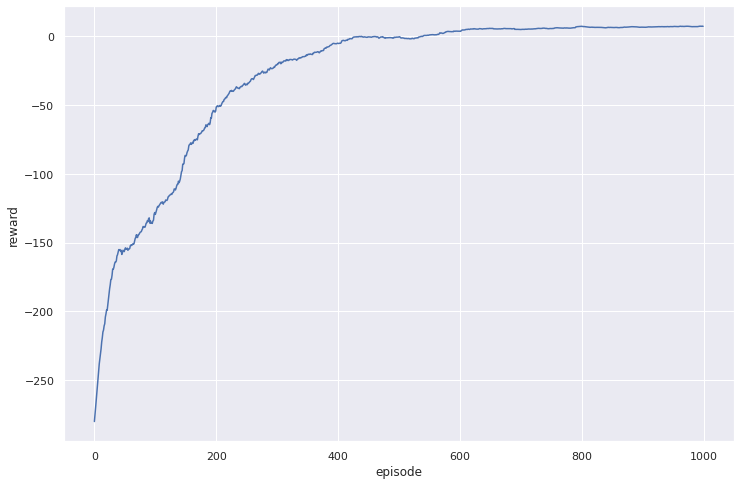

In [53]:
sns.set(rc={'figure.figsize':(12,8)})
sns_plot = sns.lineplot(x='episode', y='reward',data = data[data.episode<1000])
sns_plot.figure.savefig("tax1v3.png")